# Transfer Learning with ResNet50 for Plant Disease Classification

This notebook trains (or loads) a **ResNet50** transfer-learning model to classify plant leaf images into disease categories using the **PlantVillage** dataset.

**Workflow**
1. Import libraries and set hyperparameters  
2. Load and explore the dataset  
3. Split into train/validation/test  
4. Build a ResNet50 model (pretrained on ImageNet)  
5. Train (frozen backbone) + optional fine-tuning (unfreeze top layers)  
6. Evaluate on the test set (confusion matrix, report, error analysis)


## 1. Imports
We import the main libraries used in this notebook: TensorFlow/Keras for the CNN, NumPy for arrays, and Matplotlib for plots.


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt


## 2. Basic configuration
Set the key hyperparameters: image size, batch size, number of channels (RGB), and training epochs.


In [3]:
image_size = (256) # 256x256 pixels
batch_size = 16 # images per batch
channels = 3 # RGB
epochs = 20 # number of training epochs


## 3. Load the dataset and exploratory data analysis 
Loads images from your `PlantVillage` directory. Each subfolder name becomes a class label automatically.


In [4]:
# Load images from a folder structure into a tf.data.Dataset.
# Expected folder layout:
#   ../data/raw/PlantVillage/
#       class_1/  (images...)
#       class_2/  (images...)
#       ...
# Each subfolder name becomes the class label automatically.
dataset = tf.keras.utils.image_dataset_from_directory(
    directory = "../data/raw/PlantVillage",     # root folder containing one subfolder per class
    image_size = (image_size, image_size),      # resize every image to this fixed size (H, W)
    batch_size = batch_size                     # how many images per batch returned by the dataset
)

# Result:
# - dataset yields batches of (images, labels)
# - images shape: (batch_size, image_size, image_size, 3)
# - labels are integer class IDs (e.g., 0..num_classes-1)


Found 46955 files belonging to 10 classes.


### Class names (Ensure that the firtst letter of the name of the folder in Repo is capital )
Keras assigns an integer label to each class based on folder order. `class_names` stores the mapping.


In [5]:
# Get the list of class (label) names inferred from the subfolder names
# inside the PlantVillage directory.
# Example: ["Apple___Black_rot", "Apple___healthy", ...]
class_names = dataset.class_names

# Display / print the class names (in notebooks, the last line shows the value)
class_names 



['Bacterial_spot',
 'Early_blight',
 'Healthy',
 'Late_blight',
 'Leaf_Mold',
 'Mosaic_virus',
 'Septoria_leaf_spot',
 'Spider_mites_Two_spotted_spider_mite',
 'Target_Spot',
 'YellowLeaf__Curl_Virus']

### Inspect one batch
Checks the tensor shapes coming from the dataset and prints the label ids in that batch.


In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)   # image batch shape
    print(label_batch.numpy()) # labels as numpy


(16, 256, 256, 3)
[7 4 3 5 5 0 2 5 6 7 1 9 4 8 2 0]


### Inspect one image shape
Shows the shape of a single image tensor (height, width, channels).


In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)


(256, 256, 3)


### Inspect raw pixel values
Prints raw pixel values for one image (before rescaling).


In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].numpy())  # pixel values (array) of the first image in the batch



[[[  9.   0.   9.]
  [  7.   0.   7.]
  [  8.   0.   8.]
  ...
  [  7.   0.   7.]
  [  7.   0.   7.]
  [  7.   0.   7.]]

 [[123. 111. 123.]
  [102.  90. 102.]
  [115. 103. 115.]
  ...
  [134. 122. 134.]
  [141. 129. 141.]
  [140. 128. 140.]]

 [[129. 117. 129.]
  [102.  90. 102.]
  [115. 103. 115.]
  ...
  [127. 113. 126.]
  [136. 122. 135.]
  [137. 123. 136.]]

 ...

 [[146. 134. 146.]
  [151. 139. 151.]
  [162. 150. 162.]
  ...
  [157. 143. 158.]
  [154. 140. 155.]
  [162. 148. 163.]]

 [[145. 133. 145.]
  [149. 137. 149.]
  [160. 148. 160.]
  ...
  [161. 147. 162.]
  [156. 142. 157.]
  [166. 152. 167.]]

 [[144. 132. 144.]
  [156. 144. 156.]
  [173. 161. 173.]
  ...
  [165. 151. 166.]
  [154. 140. 155.]
  [161. 147. 162.]]]


### Visualize a sample image
Displays one example image from the dataset.


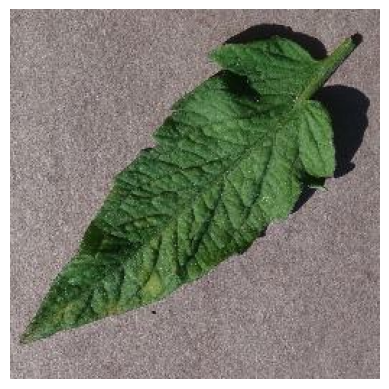

In [9]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))  # show first image (convert to uint8 for display)
    plt.axis("off")                                      # hide axes


### Label id → class name mapping
Prints the numeric label id for each class. **Note:** this cell previously contained extra code; it has been cleaned to only show the mapping.


In [10]:
for label_id, class_name in enumerate(dataset.class_names):
    print(f"{label_id} : {class_name}")  # print: class_index : class_name



0 : Bacterial_spot
1 : Early_blight
2 : Healthy
3 : Late_blight
4 : Leaf_Mold
5 : Mosaic_virus
6 : Septoria_leaf_spot
7 : Spider_mites_Two_spotted_spider_mite
8 : Target_Spot
9 : YellowLeaf__Curl_Virus


### Collect one sample per class
Unbatches the dataset and stores the first image seen for each class. This is useful for later visualization.


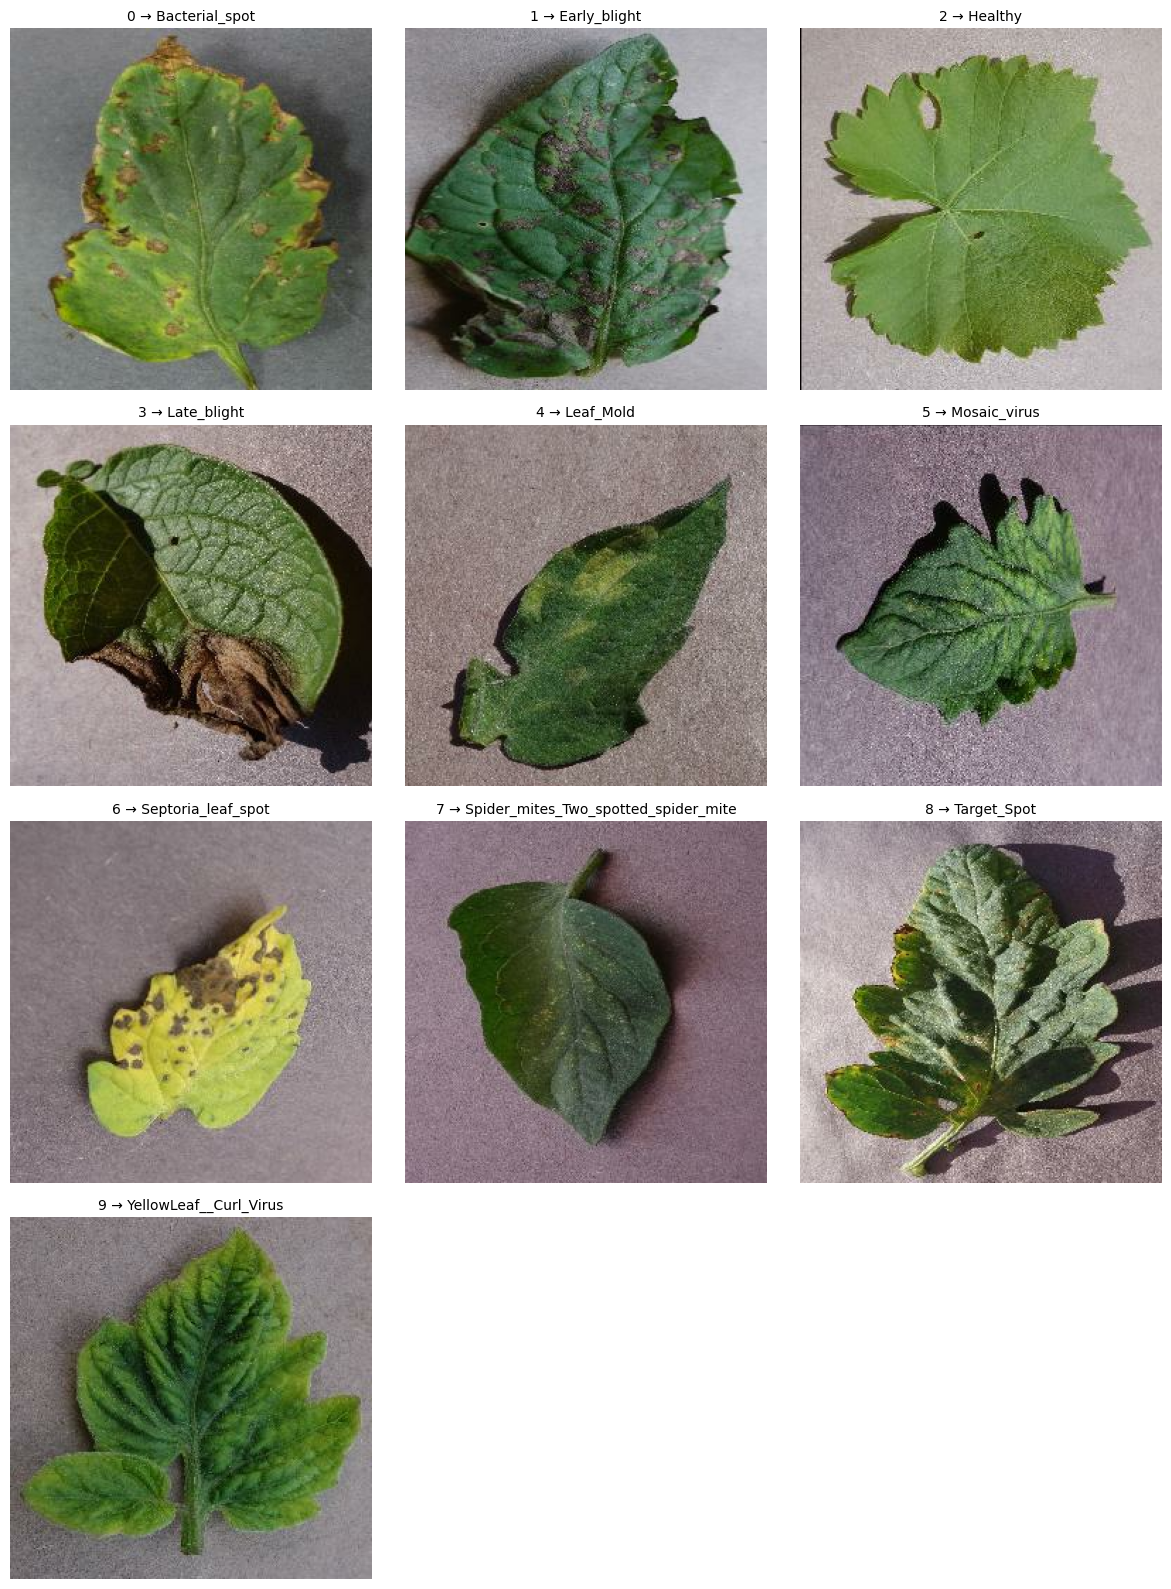

In [11]:
import math

class_names = dataset.class_names                 # class names (from folder names)
num_classes = len(class_names)                    # number of classes

samples = {}                                      # store 1 sample image per class

for img, label in dataset.unbatch():              # iterate image-by-image (not in batches)
    label_id = int(label.numpy())                 # tensor -> int
    if label_id not in samples:
        samples[label_id] = img                   # keep the first image for this class
    if len(samples) == num_classes:
        break                                     # stop after collecting all classes

cols = 3
rows = math.ceil(num_classes / cols)              # rows needed for the grid

plt.figure(figsize=(4*cols, 4*rows))
for i, label_id in enumerate(sorted(samples.keys())):
    ax = plt.subplot(rows, cols, i + 1)           # position in the grid

    img = samples[label_id].numpy().astype("uint8")  # convert to display format
    plt.imshow(img)                               # show image
    plt.title(f"{label_id} → {class_names[label_id]}", fontsize=10)  # label + name
    plt.axis("off")                               # hide axes

plt.tight_layout()                                # nicer spacing
plt.show()                                        # render the figure


## 4. Train/validation/test split
Splits a `tf.data.Dataset` into train/val/test using `take()` and `skip()`. This assumes the dataset has a known length.


In [12]:
def spliting_the_data(ds, train_split=0.80, val_split=0.10, test_split=0.10, shuffle=True, shuffle_size=1000):
    ds_size = len(ds)                          # total number of batches/elements in ds

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12) # shuffle before splitting

    train_size = int(train_split * ds_size)    # number of items for train
    val_size   = int(val_split * ds_size)      # number of items for val

    train_ds = ds.take(train_size)             # first part -> train
    val_ds   = ds.skip(train_size).take(val_size)  # next part -> val
    test_ds  = ds.skip(train_size).skip(val_size)  # remaining -> test

    return train_ds, val_ds, test_ds           # return the 3 datasets


### Create the splits
Runs the split function and produces `train_ds`, `val_ds`, and `test_ds`.


In [33]:
train_ds, val_ds, test_ds = spliting_the_data(dataset)  # split dataset into train/val/test



### Check split sizes
Shows the number of batches in each split (may be `unknown` in some pipelines).


In [34]:
len(train_ds), len(val_ds), len(test_ds)  # number of batches/items in each split

(2348, 293, 294)

## 5. Preprocessing and data augmentation
- **Resizing** ensures all images have the same shape.
- **Rescaling** normalizes pixels to `[0, 1]`
- **Background detection** diferentiat leaf area from the background and randomly change the background color. 
- **Augmentation** creates random flips/rotations to improve generalization.
- **ResNet50 preprocessing** converts images to the exact format expected by ImageNet-pretrained ResNet50 weights.


This augmentation improves real-world generalization by randomly replacing the image background during training. It estimates the background from the image borders, keeps the foreground (leaf + disease symptoms), and replaces only the background with a random color/texture. This helps the model learn disease patterns instead of relying on clean/consistent backgrounds, improving performance on different backgrounds and real phone photos.


In [35]:
# =========================
# 1) Background replacement (border-based) — TRAINING ONLY
# =========================
def background_replace_border_only(x):
    """
    x: float32 in [0,1], shape (B,H,W,3)
    Replaces background using border-based estimation (keeps brown/yellow symptoms too).
    Always applies (probability is handled in the layer).
    """
    B = tf.shape(x)[0]
    H = tf.shape(x)[1]
    W = tf.shape(x)[2]

    # Border pixels
    top    = x[:, 0, :, :]           # (B,W,3)
    bottom = x[:, H-1, :, :]
    left   = x[:, :, 0, :]           # (B,H,3)
    right  = x[:, :, W-1, :]

    border = tf.concat([top, bottom, left, right], axis=1)   # (B, 2W+2H, 3)

    # Background color estimate per image
    bg = tf.reduce_mean(border, axis=1, keepdims=True)       # (B,1,3)
    bg = tf.reshape(bg, [B, 1, 1, 3])                        # (B,1,1,3)

    # Foreground mask = pixels far from background
    dist = tf.reduce_sum(tf.square(x - bg), axis=-1, keepdims=True)  # (B,H,W,1)
    mean = tf.reduce_mean(dist, axis=[1,2,3], keepdims=True)
    std  = tf.math.reduce_std(dist, axis=[1,2,3], keepdims=True)
    thr  = mean + 0.5 * std

    mask = tf.cast(dist > thr, tf.float32)

    # Smooth mask slightly (reduces holes)
    mask = tf.nn.avg_pool(mask, ksize=5, strides=1, padding="SAME")
    mask = tf.cast(mask > 0.5, tf.float32)

    # Random solid background per image
    rand_color = tf.random.uniform([B, 1, 1, 3], 0.0, 1.0, dtype=x.dtype)

    out = x * mask + rand_color * (1.0 - mask)
    return tf.clip_by_value(out, 0.0, 1.0)


@tf.keras.utils.register_keras_serializable()
class RandomBackgroundReplace(layers.Layer):
    """
    Applies background replacement ONLY during training, with probability p.
    Does nothing during validation/inference.

    Note: registered + serializable so model.save / load_model works reliably.
    """
    def __init__(self, p=0.35, **kwargs):
        super().__init__(**kwargs)
        self.p = p

    def call(self, x, training=None):
        training = tf.constant(False) if training is None else tf.cast(training, tf.bool)

        def train_fn():
            return tf.cond(
                tf.random.uniform([]) < self.p,
                lambda: background_replace_border_only(x),
                lambda: x
            )

        return tf.cond(training, train_fn, lambda: x)

    def get_config(self):
        config = super().get_config()
        config.update({"p": self.p})
        return config


@tf.keras.utils.register_keras_serializable()
class ResNet50Preprocess(layers.Layer):
    """
    ResNet50 expects ImageNet-style preprocessing (BGR + mean subtraction) on pixels in [0..255].
    Our pipeline augments in [0..1] for convenience, then converts here.

    Registered + serializable so the saved .keras model loads on Windows/Linux.
    """
    def call(self, x):
        x = tf.cast(x, tf.float32)
        x = x * 255.0
        return tf.keras.applications.resnet50.preprocess_input(x)

    def get_config(self):
        return super().get_config()



In [36]:
# =========================
# 2) Resize/Rescale + Strong "Wild" Augmentation (same style as your notebook)
# =========================
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(image_size + 32, image_size + 32),   # room for random crop (wild photos)
    layers.Rescaling(1.0/255)                            # normalize to [0,1]
])

data_augmentation = tf.keras.Sequential([
    layers.RandomCrop(image_size, image_size),           # reduces background shortcuts

    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.25),
    layers.RandomZoom(0.25),
    layers.RandomTranslation(0.12, 0.12),

    layers.RandomContrast(0.35),

    RandomBackgroundReplace(p=0.35),                     # background randomization (TRAINING ONLY)

    layers.GaussianNoise(0.03),                          # phone/compression noise
])


## 6. Build the ResNet50 model (transfer learning)


### Model architecture
We use **ResNet50** (pretrained on ImageNet) as a feature extractor backbone, then add a small custom classification head for PlantVillage.

Training is typically done in **two stages**:
1) **Frozen backbone**: train only the new top layers (fast + stable)
2) **Fine-tuning** (optional): unfreeze the top part of ResNet50 and continue with a smaller learning rate



In [37]:
input_shape = (image_size, image_size, channels)   # shape of one image (H, W, C)

class_names = dataset.class_names                  # class labels (folder names)
class_names                                       # display class names
n_classes = len(class_names)                       # number of classes

# -----------------------------
# ResNet50 backbone (ImageNet pretrained)
# -----------------------------
base_model = tf.keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,                            # remove ImageNet classifier head
    input_shape=input_shape
)
base_model.trainable = False                      # freeze backbone for stage 1 training

# -----------------------------
# Full model (keep the same Sequential style as your notebook)
# -----------------------------
model = models.Sequential([
    layers.InputLayer(input_shape=input_shape),   # explicit input layer (clean shape inference)

    resize_and_rescale,                           # resize + normalize to [0,1]
    data_augmentation,                            # strong augmentation (TRAINING ONLY)

    ResNet50Preprocess(),                         # convert to ResNet50 expected preprocessing
    base_model,                                   # feature extractor

    layers.GlobalAveragePooling2D(),              # feature maps -> vector
    layers.Dropout(0.30),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.20),

    layers.Dense(n_classes, activation="softmax")  # output probabilities
])

model.build((None, image_size, image_size, channels))  # create model weights with batch dim = None
model.summary()                                        # show model layers + parameters



Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_14 (Sequential)  (None, 288, 288, 3)       0         
                                                                 
 sequential_15 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                               

### Compile the model
Sets the optimizer, loss function, and metrics. `SparseCategoricalCrossentropy` is correct when labels are integer-encoded.


In [38]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # a good default for transfer learning
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

model.summary()  # show model architecture + parameters



Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_14 (Sequential)  (None, 288, 288, 3)       0         
                                                                 
 sequential_15 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 127, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                               

### Early stopping 

In [39]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau  # training callbacks

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",              # watch validation loss
        mode="min",                      # lower is better
        patience=9,                      # stop if no improvement for 9 epochs
        restore_best_weights=True        # keep best weights found
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.keras",              # file to save best model
        monitor="val_loss",
        mode="min",
        save_best_only=True              # save only when val_loss improves
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        mode="min",
        factor=0.5,                      # reduce LR by half
        patience=2,                      # wait 2 epochs without improvement
        min_lr=1e-6,                     # don't go below this LR
        verbose=1                        # print when LR changes
    )
]


### GPU setup (optional)
Enables memory growth so TensorFlow doesn't reserve all GPU memory at once.


In [40]:
import tensorflow as tf  # TensorFlow library

gpus = tf.config.list_physical_devices('GPU')          # list available GPUs
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True) # use GPU memory as needed (avoid full pre-allocation)

print("GPUs:", gpus)                                   # show detected GPUs



GPUs: []


### Train or load a saved model
Use `TRAIN = True` to train and save, or `TRAIN = False` to load the saved model from disk.

**Tip:** With ResNet50, you usually train in 2 stages: frozen backbone first, then optional fine-tuning with a smaller learning rate.
This cell supports that via `FINE_TUNE = True/False`.



In [41]:
import os                                   # file/path utilities
from datetime import datetime                # (not used here, can remove)
import tensorflow as tf                      # TensorFlow

MODEL_PATH = "../models/image_classification_model.keras"  # where to save/load the model
TRAIN = True                                # True = train + save, False = load existing model

# ResNet50 fine-tuning controls (optional)
FINE_TUNE = True                            # set False to skip fine-tuning
FINE_TUNE_EPOCHS = 10                       # extra epochs after unfreezing
FINE_TUNE_AT = -30                          # unfreeze last 30 layers (negative = from the end)

# Make sure the folder exists
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

if TRAIN:
    print("Training model (frozen ResNet50 backbone)...")
    model_history = model.fit(
        train_ds,                            # training dataset
        validation_data=val_ds,              # validation dataset
        epochs=epochs,                       # number of epochs
        callbacks=callbacks,                 # callbacks (early stop, checkpoint, etc.)
        verbose=1
    )

    if FINE_TUNE:
        print("Fine-tuning (unfreezing the top of ResNet50)...")

        base_model.trainable = True

        # Decide where to start fine-tuning
        if isinstance(FINE_TUNE_AT, int) and FINE_TUNE_AT < 0:
            fine_tune_at = len(base_model.layers) + FINE_TUNE_AT
        else:
            fine_tune_at = int(FINE_TUNE_AT)

        # Freeze all layers before fine_tune_at
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False

        # Re-compile with a smaller learning rate for fine-tuning
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=["accuracy"]
        )

        fine_tune_history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=FINE_TUNE_EPOCHS,
            callbacks=callbacks,
            verbose=1
        )

    model.save(MODEL_PATH)                   # save trained model
    print("Saved model to:", MODEL_PATH)

else:
    if os.path.exists(MODEL_PATH):           # check model file exists
        print("Loading saved model...")
        model = tf.keras.models.load_model(MODEL_PATH)  # load saved model
        print("Loaded model from:", MODEL_PATH)
    else:
        raise FileNotFoundError(             # error if model file is missing
            f"Model not found at: {MODEL_PATH}\n"
            "Either fix the path or set TRAIN=True to train and save the model."
        )



Training model...
Epoch 1/20

2348/2348 [==============================] - 2924s 1s/step - loss: 2.1574 - accuracy: 0.1848 - val_loss: 1.9938 - val_accuracy: 0.2502 - lr: 0.0010
Epoch 2/20
2348/2348 [==============================] - 3127s 1s/step - loss: 1.8540 - accuracy: 0.3218 - val_loss: 1.4319 - val_accuracy: 0.5029 - lr: 0.0010
Epoch 3/20
2348/2348 [==============================] - 2780s 1s/step - loss: 1.5814 - accuracy: 0.4349 - val_loss: 1.0316 - val_accuracy: 0.6494 - lr: 0.0010
Epoch 4/20
2348/2348 [==============================] - 2730s 1s/step - loss: 1.3528 - accuracy: 0.5233 - val_loss: 0.9249 - val_accuracy: 0.6872 - lr: 0.0010
Epoch 5/20
2348/2348 [==============================] - 2681s 1s/step - loss: 1.1832 - accuracy: 0.5859 - val_loss: 0.6340 - val_accuracy: 0.7837 - lr: 0.0010
Epoch 6/20
2348/2348 [==============================] - 2519s 1s/step - loss: 1.0781 - accuracy: 0.6244 - val_loss: 0.6004 - val_accuracy: 0.8006 - lr: 0.0010
Epoch 7/20
2348/2348 [=====

### Testing and model evaluation
Returns test loss and test accuracy.


In [42]:
if "scores" not in globals():
    model.evaluate(test_ds, verbose=1)
else:
    print("✅ Using cached scores (not re-evaluating).")

print("metrics:", model.metrics_names)


294/294 [==============================] - 242s 241ms/step - loss: 0.1852 - accuracy: 0.9347
metrics: ['loss', 'accuracy']


### Predict labels on the test set
Collects true labels and predicted labels so we can build a classification report and confusion matrix.


In [43]:
y_true_list = []                      # store true labels from all batches
y_pred_list = []                      # store predicted labels from all batches

for x_batch, y_batch in test_ds:      # loop over test batches (images, labels)
    probs = model.predict(x_batch, verbose=0)   # predicted class probabilities
    y_pred_batch = np.argmax(probs, axis=1)     # pick class with highest probability

    y_true_batch = y_batch.numpy()    # true labels as numpy

    y_true_list.append(y_true_batch)  # collect true labels
    y_pred_list.append(y_pred_batch)  # collect predicted labels

y_true = np.concatenate(y_true_list)  # merge all true labels into one array
y_pred = np.concatenate(y_pred_list)  # merge all predictions into one array

print("Manual test accuracy:", (y_true == y_pred).mean())  # compare with model.evaluate accuracy


Manual test accuracy: 0.9300595238095238


### Confusion matrix plot
Shows where the model confuses one class for another.


<Figure size 1000x800 with 0 Axes>

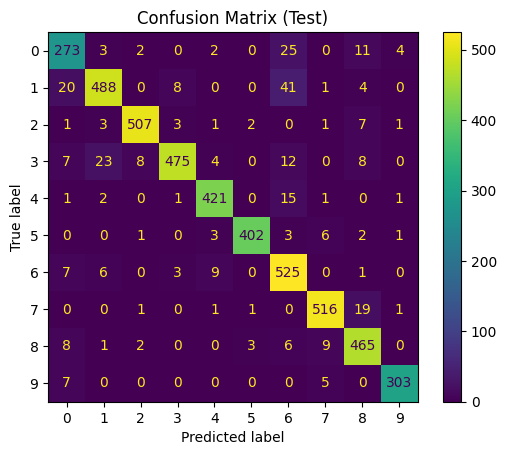

In [44]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # confusion matrix tools

cm = confusion_matrix(y_true, y_pred)      # build confusion matrix from true vs predicted labels

plt.figure(figsize=(10, 8))               # set figure size
disp = ConfusionMatrixDisplay(confusion_matrix=cm)  # wrap matrix for plotting
disp.plot(values_format="d")              # plot counts as integers
plt.title("Confusion Matrix (Test)")      # title
plt.show()                                # display plot


### Classification report
Precision/recall/F1-score per class, plus macro and weighted averages.


In [45]:
from sklearn.metrics import classification_report
cm = confusion_matrix(y_true, y_pred)  # compute confusion matrix

print(classification_report(
    y_true, y_pred,                    # true labels vs predicted labels
    target_names=class_names,          # show class names instead of numbers
    digits=4                           # print metrics with 4 decimals
))



                                      precision    recall  f1-score   support

                      Bacterial_spot     0.8426    0.8531    0.8478       320
                        Early_blight     0.9278    0.8683    0.8971       562
                             Healthy     0.9731    0.9639    0.9685       526
                         Late_blight     0.9694    0.8845    0.9250       537
                           Leaf_Mold     0.9546    0.9525    0.9536       442
                        Mosaic_virus     0.9853    0.9617    0.9734       418
                  Septoria_leaf_spot     0.8373    0.9528    0.8913       551
Spider_mites_Two_spotted_spider_mite     0.9573    0.9573    0.9573       539
                         Target_Spot     0.8994    0.9413    0.9199       494
              YellowLeaf__Curl_Virus     0.9743    0.9619    0.9681       315

                            accuracy                         0.9301      4704
                           macro avg     0.9321    0.9297    0

### Inspect wrong predictions
Collects a few misclassified examples so you can visually check what went wrong.


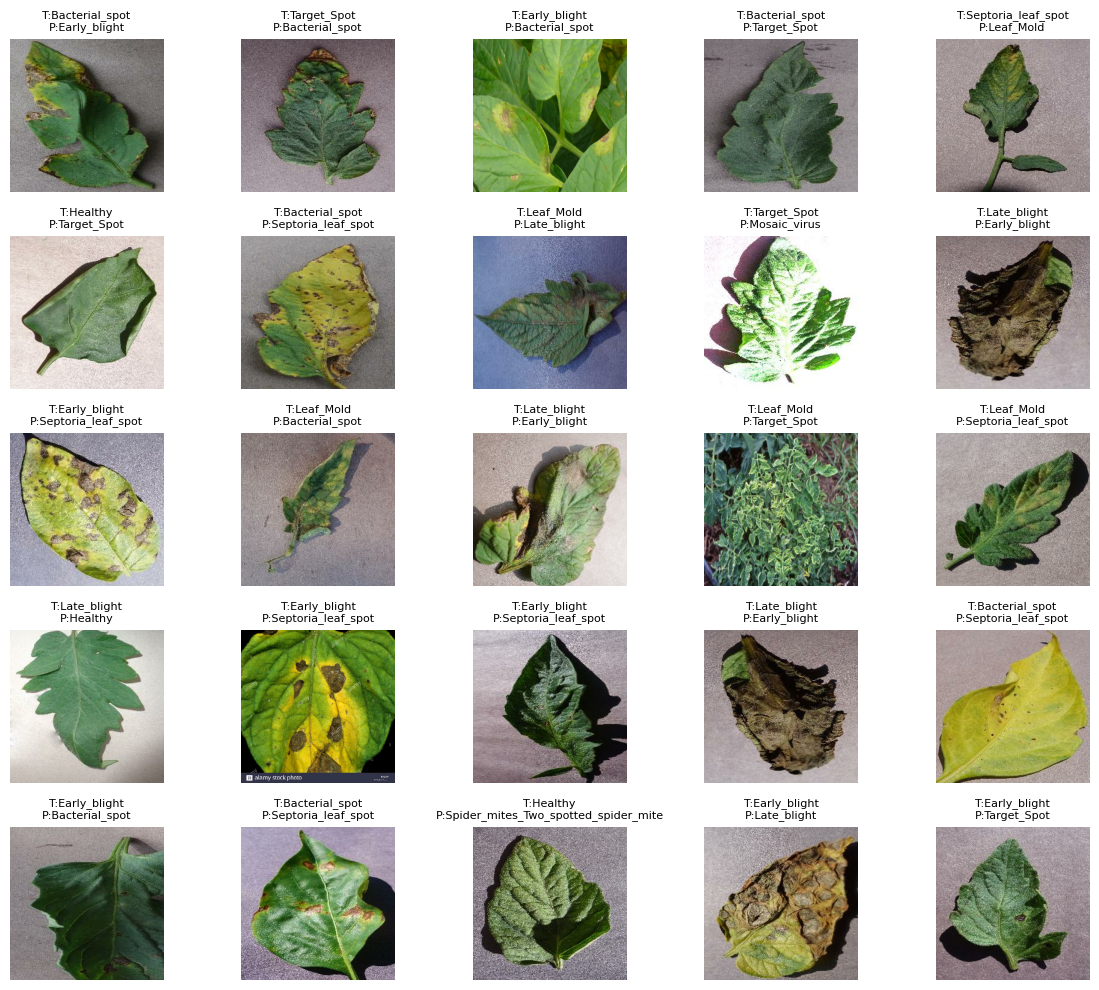

In [47]:
import matplotlib.pyplot as plt   # plotting
import numpy as np                # arrays

wrong = []  # store (image, true_label, pred_label) for mistakes

for x_batch, y_batch in test_ds:                      # loop over test batches
    probs = model.predict(x_batch, verbose=0)         # predict probabilities
    pred = np.argmax(probs, axis=1)                   # predicted class ids

    if len(y_batch.shape) > 1 and y_batch.shape[-1] > 1:  # if labels are one-hot
        true = np.argmax(y_batch.numpy(), axis=1)          # convert to class ids
    else:
        true = y_batch.numpy().astype(int)                 # sparse labels -> int

    for i in range(len(true)):                             # check each item in batch
        if true[i] != pred[i]:
            wrong.append((x_batch[i].numpy().astype("uint8"), true[i], pred[i]))  # save mistake
    if len(wrong) >= 25:
        break                                              # stop after collecting 25 mistakes

plt.figure(figsize=(12, 10))                               # create figure
for i, (img, t, p) in enumerate(wrong[:25]):               # plot up to 25 wrong images
    plt.subplot(5, 5, i+1)
    plt.imshow(img)                                       # show image
    t_name = class_names[t] if "class_names" in globals() else str(t)  # true name
    p_name = class_names[p] if "class_names" in globals() else str(p)  # pred name
    plt.title(f"T:{t_name}\nP:{p_name}", fontsize=8)       # title (T=true, P=pred)
    plt.axis("off")                                       # hide axes
plt.tight_layout()                                        # spacing
plt.show()                                                # display


### Error analysis 

In [29]:
import numpy as np  # arrays + numerical ops

pairs = []                          # store (count, true_class_name, predicted_class_name)
n = len(class_names)                # number of classes

for i in range(n):                  # loop over true class index
    for j in range(n):              # loop over predicted class index
        if i != j and cm[i, j] > 0: # keep only mistakes (off-diagonal) with count > 0
            pairs.append((cm[i, j], class_names[i], class_names[j]))  # save this confusion pair

for c, true_name, pred_name in sorted(pairs, reverse=True)[:15]:  # top 15 biggest confusions
    print(f"{c:>3}  True: {true_name:30s}  → Pred: {pred_name}")   # print nicely formatted


 10  True: Spider_mites_Two_spotted_spider_mite  → Pred: Healthy
  7  True: Spider_mites_Two_spotted_spider_mite  → Pred: Target_Spot
  7  True: Leaf_Mold                       → Pred: Septoria_leaf_spot
  6  True: Target_Spot                     → Pred: Spider_mites_Two_spotted_spider_mite
  6  True: Early_blight                    → Pred: Septoria_leaf_spot
  5  True: Bacterial_spot                  → Pred: Early_blight
  4  True: Septoria_leaf_spot              → Pred: Early_blight
  4  True: Septoria_leaf_spot              → Pred: Bacterial_spot
  3  True: Late_blight                     → Pred: Early_blight
  2  True: Target_Spot                     → Pred: Healthy
  2  True: Mosaic_virus                    → Pred: Septoria_leaf_spot
  2  True: Leaf_Mold                       → Pred: Spider_mites_Two_spotted_spider_mite
  2  True: Leaf_Mold                       → Pred: Mosaic_virus
  2  True: Bacterial_spot                  → Pred: YellowLeaf__Curl_Virus
  1  True: YellowLeaf__Cu

The main remaining errors are concentrated in a few visually similar categories—especially Spider_mites → Target_Spot (9) and Spider_mites → healthy (8), plus smaller mix-ups like Septoria_leaf_spot → Early_blight (5). This is reasonable because these classes can share similar “spotty” textures, and symptoms may be subtle or appear in early stages, making the visual cues harder even for humans.